In [1]:
import pandas as pd
import glob
from pathlib import Path
from pandas import DataFrame
from pandas import Series, DataFrame
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import pearsonr, norm
import nltk
import nltk.stem

In [2]:
# load stopwords
from sklearn.feature_extraction import text
text_file = open('/Users/zejiachen/Desktop/fall 2021/QTM 340/Final Project/Notebook/jockers_stopwords.txt') # your path will be different!
jockers_words = text_file.read().split()
new_stopwords = text.ENGLISH_STOP_WORDS.union(jockers_words)


In [3]:
# remove stemmed words
english_stemmer = nltk.stem.SnowballStemmer('english')

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

In [4]:
filmNolan = pd.read_csv('/Users/zejiachen/Desktop/fall 2021/QTM 340/Final Project/filmNolan.csv')

In [5]:
filmNolan

,Unnamed: 0,Film,Rating,Comments,overall,negative,neutral,positive,compound
0,0,interstellar,★★★★★,"I have a headache, but it's the best headache ...",5.0,0.000,0.608,0.392,0.7783
1,1,interstellar,★★★★★,tell me you wouldn't cry too if your son grows...,5.0,0.000,0.846,0.154,0.3724
2,2,interstellar,★★★★★,I'm pretty sure no one will EVER come close to...,5.0,0.178,0.594,0.227,0.2263
3,3,interstellar,★★★★,When those Zimmer organs kick in *biggest poss...,4.0,0.000,1.000,0.000,0.0000
4,4,interstellar,★★★★★,i needed a REALLY good cry,5.0,0.407,0.200,0.393,-0.0384
...,...,...,...,...,...,...,...,...,...
3197,3197,insomnia-2002,★★★★,Robin Williams was about as natural a villain ...,4.0,0.229,0.582,0.188,-0.2960
3198,3198,insomnia-2002,★★★★,"I loved this movie before, but now that I have...",4.0,0.156,0.694,0.151,-0.0516
3199,3199,insomnia-2002,★★★,"Guy who has only seen Twin Peaks, watching his...",3.0,0.000,1.000,0.000,0.0000
3200,3200,insomnia-2002,★★★★,"Everybody is Al Pacino saying "" let me sleep"" ...",4.0,0.000,1.000,0.000,0.0000


In [6]:
filmNolan['letterboxdRating'] = 0

for row in range(len(filmNolan.index)):
    if filmNolan.iloc[row]['overall'] > 3:
        filmNolan.at[row, 'letterboxdRating'] = 1
    else:
        filmNolan.at[row, 'letterboxdRating'] = 0

In [7]:
sentiment = filmNolan[['letterboxdRating']]

In [8]:
sentiment

,letterboxdRating
0,1
1,1
2,1
3,1
4,1
...,...
3197,1
3198,1
3199,0
3200,1


---
## Generating DTM

In [9]:
filmReview = filmNolan[['Comments']]

In [10]:
filmReview

,Comments
0,"I have a headache, but it's the best headache ..."
1,tell me you wouldn't cry too if your son grows...
2,I'm pretty sure no one will EVER come close to...
3,When those Zimmer organs kick in *biggest poss...
4,i needed a REALLY good cry
...,...
3197,Robin Williams was about as natural a villain ...
3198,"I loved this movie before, but now that I have..."
3199,"Guy who has only seen Twin Peaks, watching his..."
3200,"Everybody is Al Pacino saying "" let me sleep"" ..."


In [11]:
cvs = StemmedCountVectorizer(min_df=3, analyzer="word", stop_words= new_stopwords)

# generates document-term matrix for all the docs
dtmReview = cvs.fit_transform(filmReview['Comments'])


In [12]:
vocab = cvs.get_feature_names()
matrix = dtmReview.toarray()
dfReview = DataFrame(matrix, columns=vocab)
print('df shape is: ' + str(dfReview.shape))

df shape is: (3202, 1516)


Our dataframee has 378 rows, one for each document, or obituary, and 2985 columns, one for each word that's not in stopwords and appears at least 20 times in the corpus.

In [13]:
df_concat = pd.concat([dfReview, sentiment], axis = 1)

In [14]:
df_concat

,000,10,100,107,11,12,15,20,200,2000,...,yea,yeah,year,yep,yesterday,youtu,youtub,zero,zimmer,letterboxdRating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3198,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Equalize numbers of men and women

In [15]:
3202 - sentiment['letterboxdRating'].sum()

494

Then we separate postive and negative into two dataframes and take a random sample of 494 review about Nolan's film.

In [52]:
df_pos = df_concat[df_concat['letterboxdRating'] == 1]
df_neg = df_concat[df_concat['letterboxdRating'] == 0]
df_pos = df_pos.sample(n=494)

In [53]:
df_final = pd.concat([df_pos, df_neg])
df_final = df_final.reset_index()
df_final = df_final.drop(columns="index")
df_final.head()

,000,10,100,107,11,12,15,20,200,2000,...,yea,yeah,year,yep,yesterday,youtu,youtub,zero,zimmer,letterboxdRating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**Match meta and data dataframes with subset of df_final**

In [54]:
sentiment = df_final[["letterboxdRating"]]

In [55]:
dfReview = df_final.loc[:, :'zimmer']

---
## Run Classifier

In [56]:
sentiment['PROBS'] = ''
sentiment['PREDICTED'] = ''

<ipython-input-56-587063226cc3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment['PROBS'] = ''
<ipython-input-56-587063226cc3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment['PREDICTED'] = ''


In [57]:
model = LogisticRegression(penalty = 'l1', C = 1.0, solver='liblinear')

In [ ]:
for this_index in df_final.index.tolist():
    print(this_index) # keep track of where we are in the corpus
    CLASS = sentiment.loc[sentiment.index[this_index], 'letterboxdRating']
    print('Class:' + str(CLASS))
    
    train_index_list = [index_ for index_ in dfReview.index.tolist() if index_ != this_index] # exclude the title to be predicted
    X = dfReview.loc[train_index_list] # the model trains on all the data except the excluded title row
    y = sentiment.loc[train_index_list, 'letterboxdRating'] # the y row tells the model which class each title belongs to
    TEST_CASE = dfReview.loc[[this_index]]

    model.fit(X,y) # fit the model
    prediction = model.predict_proba(TEST_CASE) # calculate probability of test case
    predicted = model.predict(TEST_CASE) # calculate predicted class of test case
    sentiment.at[this_index, 'PREDICTED'] = predicted # add predicted class to metadata
    sentiment.at[this_index, 'PROBS'] = str(prediction) # add probabilities to metadata
    print('Class is: ' + str(CLASS) + '\n' + 'Prediction is: ' + str(predicted) + ' ' + str(prediction) + '\n')

### Meta

In [66]:
sentiment = sentiment.replace([0], 0)
sentiment = sentiment.replace([1], 1)
sentiment

,letterboxdRating,PROBS,PREDICTED,RESULT
0,1,[[0.50300677 0.49699323]],0,1
1,1,[[0.50251741 0.49748259]],0,1
2,1,[[0.49429855 0.50570145]],1,0
3,1,[[0.30480002 0.69519998]],1,0
4,1,[[0.31289203 0.68710797]],1,0
...,...,...,...,...
983,0,[[0.50095414 0.49904586]],0,0
984,0,[[0.44055345 0.55944655]],1,-1
985,0,[[0.50145765 0.49854235]],0,0
986,0,[[0.5015194 0.4984806]],0,0


In [67]:
sum_column = sentiment['letterboxdRating'] - sentiment['PREDICTED']
sentiment['RESULT'] = sum_column
sentiment

,letterboxdRating,PROBS,PREDICTED,RESULT
0,1,[[0.50300677 0.49699323]],0,1
1,1,[[0.50251741 0.49748259]],0,1
2,1,[[0.49429855 0.50570145]],1,0
3,1,[[0.30480002 0.69519998]],1,0
4,1,[[0.31289203 0.68710797]],1,0
...,...,...,...,...
983,0,[[0.50095414 0.49904586]],0,0
984,0,[[0.44055345 0.55944655]],1,-1
985,0,[[0.50145765 0.49854235]],0,0
986,0,[[0.5015194 0.4984806]],0,0


In [68]:
sentiment_correct = sentiment[sentiment['RESULT'] == 0]
sentiment_correct

,letterboxdRating,PROBS,PREDICTED,RESULT
2,1,[[0.49429855 0.50570145]],1,0
3,1,[[0.30480002 0.69519998]],1,0
4,1,[[0.31289203 0.68710797]],1,0
6,1,[[0.2031253 0.7968747]],1,0
7,1,[[0.35657679 0.64342321]],1,0
...,...,...,...,...
981,0,[[0.85783392 0.14216608]],0,0
982,0,[[0.50095413 0.49904587]],0,0
983,0,[[0.50095414 0.49904586]],0,0
985,0,[[0.50145765 0.49854235]],0,0


In [69]:
# remember our filter approach from last week's pandas class
accuracy_filter = sentiment['RESULT'] == 0

# apply the filter
accurate_results = sentiment[accuracy_filter]

# do our division 
len(accurate_results) / len(sentiment)

0.5880566801619433

**Confusion Matrix**

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

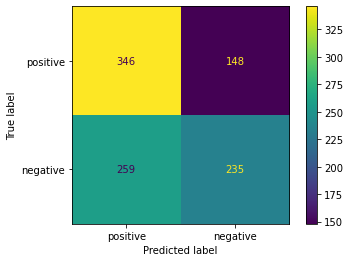

In [71]:
actual = sentiment['letterboxdRating'].array   # remember that pandas columns are Series objects, so we need to convert them
predicted = sentiment['PREDICTED'].array

cm = confusion_matrix(actual, predicted) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive','negative'])

disp.plot()
plt.show()

---
## P-values and weights

In [72]:
canonic_c = 1.0

def Ztest(vec1, vec2):

    X1, X2 = np.mean(vec1), np.mean(vec2)
    sd1, sd2 = np.std(vec1), np.std(vec2)
    n1, n2 = len(vec1), len(vec2)

    pooledSE = np.sqrt(sd1**2/n1 + sd2**2/n2)
    z = (X1 - X2)/pooledSE
    pval = 2*(norm.sf(abs(z)))

    return z, pval

In [73]:
def feat_pval_weight(meta_df_, dtm_df_):

    dtm0 = dtm_df_.loc[meta_df_[meta_df_['letterboxdRating']==0].index.tolist()].to_numpy()
    dtm1 = dtm_df_.loc[meta_df_[meta_df_['letterboxdRating']==1].index.tolist()].to_numpy()

    pvals = [Ztest(dtm0[ : ,i], dtm1[ : ,i])[1] for i in range(dtm_df_.shape[1])]
    clf = LogisticRegression(penalty = 'l1', C = canonic_c, class_weight = 'balanced', solver='liblinear')
    clf.fit(dtm_df_, meta_df_['letterboxdRating']==1)
    weights = clf.coef_[0]

    feature_df = pd.DataFrame()

    feature_df['FEAT'] = dtm_df_.columns
    feature_df['P_VALUE'] = pvals
    feature_df['LR_WEIGHT'] = weights

    return feature_df

In [74]:
feat_df = feat_pval_weight(sentiment, dfReview)
feat_df

<ipython-input-72-f8f6eb8bb85d>:10: RuntimeWarning: invalid value encountered in double_scalars
  z = (X1 - X2)/pooledSE


,FEAT,P_VALUE,LR_WEIGHT
0,000,0.413427,0.064165
1,10,0.511214,0.045642
2,100,0.762153,0.000000
3,107,0.156458,0.000000
4,11,0.156458,0.000000
...,...,...,...
1511,yesterday,0.156458,0.000000
1512,youtu,0.316820,0.000000
1513,youtub,0.316820,0.000000
1514,zero,0.412635,0.000000


In [75]:
feat_df.sort_values('LR_WEIGHT', ascending = True)

,FEAT,P_VALUE,LR_WEIGHT
163,bore,0.000013,-2.557547
1493,worst,0.002423,-1.914383
708,insomnia,0.001447,-1.615145
934,opinion,0.024610,-1.479132
1314,sure,0.050214,-1.406747
...,...,...,...
33,absolut,0.000669,1.478697
1108,rewatch,0.000384,1.532118
730,jackman,0.004350,1.559217
236,cillian,0.006159,1.674727


---

In [76]:
feat_df.sort_values('LR_WEIGHT', ascending = True).head(10)

,FEAT,P_VALUE,LR_WEIGHT
163,bore,0.000013,-2.557547
1493,worst,0.002423,-1.914383
708,insomnia,0.001447,-1.615145
934,opinion,0.024610,-1.479132
1314,sure,0.050214,-1.406747
567,fun,0.129068,-1.332766
480,expect,0.011709,-1.313868
389,disappoint,0.082328,-1.297436
197,came,0.010885,-1.285867
718,interest,0.017422,-1.027732


In [77]:
feat_df.sort_values('LR_WEIGHT', ascending = False).head(10)

,FEAT,P_VALUE,LR_WEIGHT
1135,satisfi,0.013720,2.041465
236,cillian,0.006159,1.674727
730,jackman,0.004350,1.559217
1108,rewatch,0.000384,1.532118
33,absolut,0.000669,1.478697
1417,underr,0.010739,1.469078
1429,unpredict,0.082328,1.454792
546,forev,0.007706,1.395438
1408,twist,0.033397,1.356720
782,lie,0.033085,1.235077


### More Filtering

In [78]:
sig_thresh = 50.00 / len(dfReview.columns)

sig_thresh

0.032981530343007916

In [79]:
# first set up our p-value filter
p_value_filter = feat_df['P_VALUE'] <= sig_thresh

# and filter the df
sorted_filtered_df = feat_df[p_value_filter].sort_values('LR_WEIGHT', ascending = True)

sorted_filtered_df.head()

,FEAT,P_VALUE,LR_WEIGHT
163,bore,0.000013,-2.557547
1493,worst,0.002423,-1.914383
708,insomnia,0.001447,-1.615145
934,opinion,0.024610,-1.479132
480,expect,0.011709,-1.313868


In [80]:
# no weights
no_weights_filter = sorted_filtered_df['LR_WEIGHT'] != 0

# pos weights
pos_weight_filter = sorted_filtered_df['LR_WEIGHT'] >= 0 # positive corresponds w/ positive review
# neg weights
neg_weight_filter = sorted_filtered_df['LR_WEIGHT'] <= 0 # neg corresponds w/ negative review

In [81]:
# apply the no weight filter
sorted_filtered_df = sorted_filtered_df[no_weights_filter]

sorted_filtered_df

,FEAT,P_VALUE,LR_WEIGHT
163,bore,0.000013,-2.557547
1493,worst,0.002423,-1.914383
708,insomnia,0.001447,-1.615145
934,opinion,0.024610,-1.479132
480,expect,0.011709,-1.313868
197,came,0.010885,-1.285867
718,interest,0.017422,-1.027732
1249,special,0.013720,-0.964673
425,earli,0.018961,-0.943897
585,go,0.018866,-0.906841


In [82]:
# and then separate out the pos and neg weights

positive_weights = sorted_filtered_df[pos_weight_filter] 
negative_weights = sorted_filtered_df[neg_weight_filter]

<ipython-input-82-d9a112a07975>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive_weights = sorted_filtered_df[pos_weight_filter]
<ipython-input-82-d9a112a07975>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  negative_weights = sorted_filtered_df[neg_weight_filter]


In [83]:
print("Here are the significant words that distinguish Positive Review:")
print()
words = ""

for idx, row in positive_weights.iterrows():
    words += row['FEAT'] + ", "

print(words)

print("\n")
print("Here are the significant words that distinguish Negative Review:")
print()
words = ""

for idx, row in negative_weights.iterrows():
    words += row['FEAT'] + ", "

print(words)

Here are the significant words that distinguish Positive Review:

knight, human, time, incept, ledger, incred, face, superhero, have, blockbust, truli, master, masterpiec, forev, underr, absolut, rewatch, jackman, cillian, satisfi, 


Here are the significant words that distinguish Negative Review:

bore, worst, insomnia, opinion, expect, came, interest, special, earli, go, www, high, follow, nice, doesn, concept, pacino, thriller, featur, effort, pretti, didn, small, felt, com, debut, littl, bad, couldn, 


---
## Storing Features & Models

In [51]:
feat_df.to_csv('/Users/zejiachen/Desktop/fall 2021/QTM 340/Final Project/Notebook/Letterboxd_features.csv')